**Getting our test set, transforming our categorical variables to numerical values and evaluating our first model**

In [103]:
import pandas as pd
import matplotlib as plt
import numpy as np

In [104]:
df = pd.read_csv("project-3-files/learn_dataset.csv")
df

,Id,insee_code,is_student,OCCUPATION_42,ACTIVITY_TYPE,AGE_2019,household,Highest_degree,sex,target
0,1,01001,True,csp_6_8,TYPE1|1,20,TYPMR1-1,edu.1.4,Male,B
1,2,01004,False,csp_6_5,TYPE1|1,48,TYPMR4-1,edu.1.3,Male,B
2,3,01004,False,csp_8_1,TYPE1|2,37,TYPMR4-4,edu.1.8,Female,G
3,4,01004,False,csp_4_7,TYPE1|2,65,TYPMR3-1,edu.1.6,Male,B
4,5,01004,True,csp_8_4,TYPE2|2,22,TYPMR1-2,edu.1.4,Female,B
...,...,...,...,...,...,...,...,...,...,...
49988,99979,95680,False,csp_4_6,TYPE1|1,57,TYPMR1-2,edu.1.3,Female,B
49989,99981,95680,False,csp_8_5,TYPE2|5,25,TYPMR4-1,edu.1.4,Male,G
49990,99983,95680,True,csp_8_4,TYPE2|2,19,TYPMR4-2,edu.1.4,Female,B
49991,99984,95680,False,csp_4_7,TYPE1|1,48,TYPMR4-1,edu.1.7,Male,G


In [105]:
from sklearn.model_selection import train_test_split
import sklearn
sklearn.set_config(display="diagram")

**Our mission now is to understand whether our test set is correctly stratified**

**Unfortunately, we don't know for now which feature is the most explanatory for our target (label) variable. Therefore, we'll have to leave this on the side and come back to it later. I'm not even sure this is something we can do, since categories are spread out...**

In [106]:
X = df.drop(["target", "Id"], axis="columns")
y = df['target'].copy()
y = np.where(y == 'B', 1, 0)

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

Most ML algorithms prefer to work with numbers, so let's convert these categories from text to numbers.

In [108]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

Okay so here I'll have to check the type of data we have, if it is ordinal, nominal, etc. To see whether this is the case, I have to check all the data. I'll do this in another jupyter notebook.

In [109]:
preprocessing = make_column_transformer (
    (OneHotEncoder(), ["is_student", "OCCUPATION_42", "ACTIVITY_TYPE", "household", "sex"]),
    (OrdinalEncoder(), ["Highest_degree"]), #maybe I should check if it is well encoded 
    (ce.BinaryEncoder(), ["insee_code"]),
    remainder='passthrough')
logreg = LogisticRegression(solver='lbfgs', max_iter=2000)

In [110]:
pipe = make_pipeline(preprocessing, logreg)
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['is_student',
                                                   'OCCUPATION_42',
                                                   'ACTIVITY_TYPE', 'household',
                                                   'sex']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['Highest_degree']),
                                                 ('binaryencoder',
                                                  BinaryEncoder(),
                                                  ['insee_code'])])),
                ('logisticregression', LogisticRegression(max_iter=2000))])

In [111]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['is_student',
                                                   'OCCUPATION_42',
                                                   'ACTIVITY_TYPE', 'household',
                                                   'sex']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['Highest_degree']),
                                                 ('binaryencoder',
                                                  BinaryEncoder(),
                                                  ['insee_code'])])),
                ('logisticregression', LogisticRegression(max_iter=2000))])

In [112]:
cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy").mean()

0.755588190709385

In [113]:
# If we want to test this model on new data, here is the code
# pipe.fit(X, y)
# pipe.predict(X_new)

In [114]:
y_pred = pipe.predict(X_train)

In [115]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Paramètres pour GridSearchCV
param_grid = {
    'logisticregression__C': [40, 100, 200],  # Coefficients de régularisation
    'logisticregression__penalty': ['l2']  # Normes de régularisation
}

# Initialisation de GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')

# Entraînement avec GridSearchCV
grid_search.fit(X_train, y_train)

# Meilleurs paramètres et meilleur score
print("Meilleurs paramètres: ", grid_search.best_params_)
print("Meilleur score de cross-validation: ", grid_search.best_score_)

# Utiliser le meilleur modèle pour prédire les données de test
y_pred = grid_search.predict(X_test)

# Calculer des métriques de performance
print("Précision: ", accuracy_score(y_test, y_pred))
print("Rappel: ", recall_score(y_test, y_pred))
print("Score F1: ", f1_score(y_test, y_pred))

# Générer des graphiques
# ...



Meilleurs paramètres:  {'logisticregression__C': 200, 'logisticregression__penalty': 'l2'}
Meilleur score de cross-validation:  0.7555882063402463
Précision:  0.7608760876087609
Rappel:  0.8568174422388546
Score F1:  0.8149810415538188


I'd like to test the decision function of our logistic classifier. I have to import cross_val_predict() to get the scores of all instances in the training set, but this time specify that I want to return decision scores instead of predictions.

In [116]:
from sklearn.model_selection import cross_val_predict

In [117]:
y_scores = cross_val_predict(pipe, X_train, y_train, cv=3, method="decision_function")
y_scores

array([ 1.04272572, -1.97688071,  2.60545163, ...,  1.46283303,
       -0.53702526, -2.50992389])

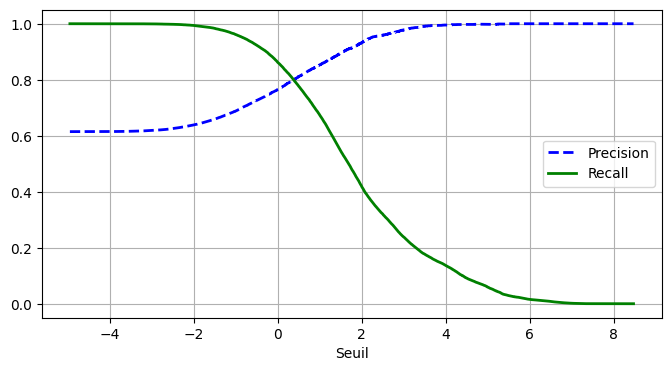

In [118]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.xlabel("Seuil")
plt.legend(loc="center right")
plt.grid()

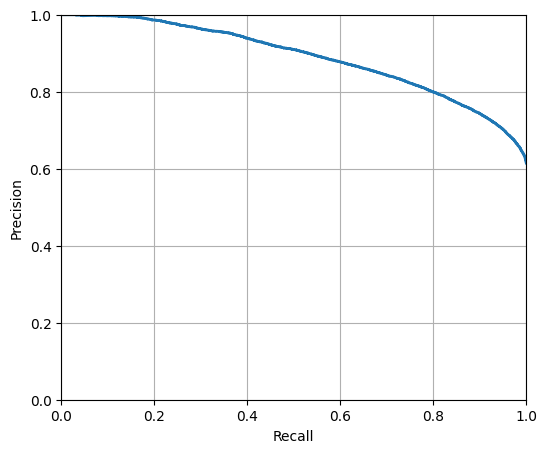

In [119]:
plt.figure(figsize=(6, 5)) 
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()

0.8360671957706367


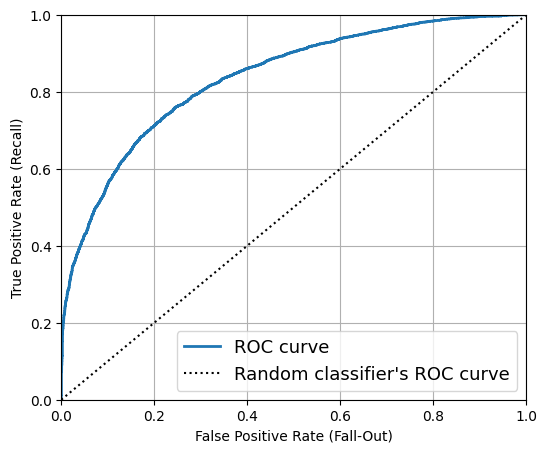

In [120]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


y_scores_test = pipe.decision_function(X_test)


# Calculer les taux de faux et vrais positifs
fpr, tpr, thresholds = roc_curve(y_test, y_scores_test)

# Calculer l'aire sous la courbe ROC
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
plt.grid()

Let's now use a RandomForestClassifier, whose precision/recall curve and F1 score we can compare to those of the Logistic Classifier

In [121]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=0)
pipe = make_pipeline(preprocessing, forest_clf)

In [122]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['is_student',
                                                   'OCCUPATION_42',
                                                   'ACTIVITY_TYPE', 'household',
                                                   'sex']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['Highest_degree']),
                                                 ('binaryencoder',
                                                  BinaryEncoder(),
                                                  ['insee_code'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=0))])

In [123]:
cross_val_score(pipe, X_train, y_train, cv=3, scoring="accuracy").mean()

0.756563357933573

In [124]:
y_probas_forest = cross_val_predict(pipe, X_train, y_train, cv=3, method="predict_proba")

In [125]:
y_probas_forest[:2]

array([[0.35, 0.65],
       [0.61, 0.39]])

In [126]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train, y_scores_forest)

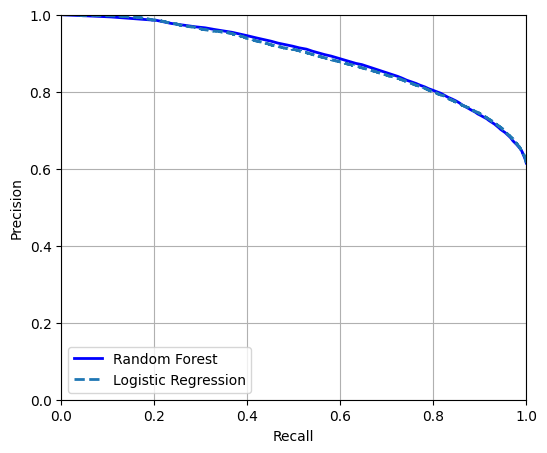

In [127]:
plt.figure(figsize=(6, 5))

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="Logistic Regression")

# extra code – just beautifies and saves Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")


We can see that their performance is roughly the same, although random forest takes a lot more time to get the same results. The reason why those two curves seem to be similar is because they have reached their full potential, and sometimes different models can lead to similar results. As long as we don't have more data to feed the mode, it will hard to differentiate from those two. However, maybe I miscoded something, but it doesn't seem so since the two curves aren't exactly on the same coordinates.

What is yet to do:
Choose the right tradeoff between precision & recall, we can do this once we have more data.

**In another section, maybe we could try to optimise other binary classifiers : SGDClassifier and SVC.**